In [3]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers.convolutional import Cropping2D
import keras

%matplotlib inline

Using TensorFlow backend.


# Training data

I have 2 "runs" of training data that were collected in different folders to make using each one, or both, easy to choose.
 
The first 'data' folder contains 1 lap of centre driving, the second 'data2' folder contains recovery driving, where I would turn recording off, drive to the edge of the track, turn recording off, and record myself 'recovering' back to the middle of the road.

The data all fit in memory for me so I did not spend time to create a generator. 

I first trained my model using only centre images, but ended up using all three camera images and adding a correction factor of +/- 0.2 to the steering angle. I found this to be one of the best improvements in the model.

I also re-ordered the colour channels during loading data to maintain consistency between training and inference - using RGB for both.


In [4]:

images = []
steerings = []

folders = ['data', 'data2']

def read_rgb(filename):
    bgr_image = cv2.imread(filename)
    b,g,r = cv2.split(bgr_image)
    return cv2.merge([r,g,b])

for folder in folders:
    with open(folder + '/driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            centre_filename = os.path.basename(line[0])
            left_filename = os.path.basename(line[1])
            right_filename = os.path.basename(line[2])

            centre_img = read_rgb(folder + '/IMG/' + centre_filename)
            left_img = read_rgb(folder + '/IMG/' + left_filename)
            right_img = read_rgb(folder + '/IMG/' + right_filename)

            centre_angle = float(line[3])
            left_angle = centre_angle + 0.2
            right_angle = centre_angle - 0.2

            images.append(centre_img)
            steerings.append(centre_angle)

            images.append(left_img)
            steerings.append(left_angle)

            images.append(right_img)
            steerings.append(right_angle)
        

train_X = np.array(images)
train_y = np.array(steerings)

print(train_X.shape)
print(train_y.shape)


(7971, 160, 320, 3)
(7971,)


# Review Training Data

First we need to check that we are correctly using the centre, left and right images

## Centre image and angle

0.0


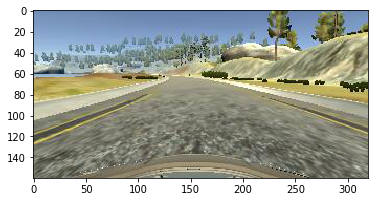

In [6]:
plt.imshow(train_X[0,:,:,:])
print(train_y[0])

## Left image

0.2


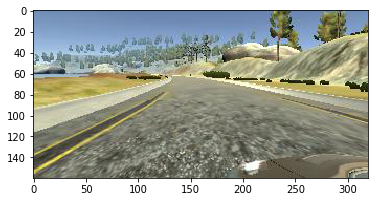

In [7]:
plt.imshow(train_X[1,:,:,:])
print(train_y[1])

## Right image

-0.2


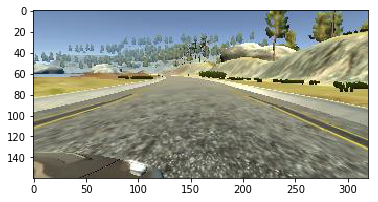

In [8]:
plt.imshow(train_X[2,:,:,:])
print(train_y[2])

# Choosing region of interest

The top part of the image above the horizon has a lot of noise (trees, etc...) which could confuse the model. So I have chosen to crop the top 60 pixels out.

The bottom of the model contains the car hood, which is not very useful for direction. Also I think it would be better to remove the road part that is very close to the car. As a human driver, we look further down the road to make decisions, and if we were only looking at the road 1-3 m infront we would struggle to drive well. For these reasons I have cropped the lower 20 pixels of the image

(160, 320, 3)
(80, 320, 3)


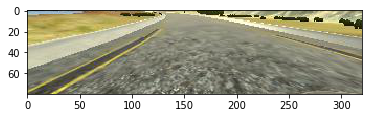

In [9]:
img = train_X[1,:,:,:]
print(img.shape)
print(img[60:-20, :].shape)
plt.imshow(img[60:-20, :])

# Model architechture

I have used the principle of only adding complexity when needed, as have found this prevents situations where you have a complex model which is not working as expecte. Those situations become very time consuming to debug, as there are many options and there is a lack of knowledge about which option might fix it. In the past I have used random guesses to try to fix the complex model, before resorting to simplifying and rebuilding. For this reason I have chosen LeNet as a starting CNN as is it is simple and fast to train.

I have added preprocessing layers also:
- Cropping layer to select the region of interest. This has to be done in the model, not before, as we need to read full-frame images from the simulator and crop them at inference time.
- Average pooling layer to reduce the resolution of the input image. This is useful because, when I looked at the features needed to output the steering angle, I noticed they were all large (road marking, kerbs, etc...). I do not want the model to be overfitting noise (e.g. the road surface) and so by reducing the resolution I found the model more robust.
- Normalisation layer to keep the image pixels centred around 0 for numerical stability. 

I did not need to add dropout as the model was able to drive around the whole track without doing so. I believe the reduced resolution helped robustness here.

In [24]:
model = Sequential()

model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=(160,320,3)))
model.add(keras.layers.AveragePooling2D())
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(keras.layers.Convolution2D(6, 5, 5, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Convolution2D(6, 5, 5, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_2 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_2[0][0]         
____________________________________________________________________________________________________
averagepooling2d_2 (AveragePooli (None, 40, 160, 3)    0           cropping2d_2[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 40, 160, 3)    0           averagepooling2d_2[0][0]         
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 36, 156, 6)    456         lambda_2[0][0]                   
___________________________________________________________________________________________

# Stopping Condition

I initially used the Keras 'EarlyStopping' callback to stop training once the validation error did not decrease.

However I reverted back to hardcoding the number of epochs as one model did indeed train for 8-9 epochs with extremely small improvements in validation error for the last 4-5 epochs. (E.g. 0.082 -> 0.081 -> 0.080 -> 0.080). This model did not perform well (I believe it was overfitting).

I stopped training after 3 epochs as I found the validation error was not improving much beyond this point, and I wanted to avoid overfitting.

In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

# model.fit(train_X, train_y, validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.fit(train_X, train_y, validation_split=0.2, shuffle=True, nb_epoch=3)


Train on 6376 samples, validate on 1595 samples
Epoch 1/3
6376/6376 [==============================] - 28s - loss: 0.0489 - val_loss: 0.0352
Epoch 2/3
6376/6376 [==============================] - 29s - loss: 0.0261 - val_loss: 0.0340
Epoch 3/3
6376/6376 [==============================] - 28s - loss: 0.0223 - val_loss: 0.0401


In [26]:
model.save('model3.h5')

# Conclusion

I faced many difficulties when completing this project.

## Measuring progress
Firstly it was difficult to know if I was making progress. Before using the left and right camera angles I struggled to drive any distance without driving off immediately. The videos presented a fully connected model (non-CNN) driving better than I was able to with LeNet. I had even recoreded recovery driving at this point.

I then did some research using the helpful notes made by Paul Heraty. I realised there were many things to try. These options, plus some more of my own thoughts became a long list. I tried to prioritise them in terms of time it would take to implement along with chance of it making improvements.

After this I realised that better input data was the fastest + least risky things to try. I cropped the image and reduced resolution, and fixed the BGR-> RGB issue and suddenly my simple LeNet model was driving a resonable distance. I then added the left and right images and was able to go around the track!

I also wanted to remove risk in having bad input data first, as trying deeper models with poor input data was likely to lead to difficult situations

# Next steps

If I had more time (which sadly full time work + family commitments limit) I would try other model archtechtures. Although my model is able to drive round the track, I did not increase the speed untill trying to record the video for submission. I now realise that at higher speeds the driving suffers.

I would also try to think of ways to increase the feedback cycle -> if it means being able to start at different parts of the track, or writing an automated test setup (like automated CI server) to drive around at faster and faster speeds. So I do not have to manually babysit the evaluation process. Having said this, watching the model to see how it drives and fails is useful when thinking of what to do to improve.
